<a href="https://colab.research.google.com/github/bradbradlin/Machine-Learning-Projects/blob/main/Speech_Emotion_Recognition_(Train)_TRILL_19_%2B_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2020/7/20

https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/
https://towardsdatascience.com/how-to-build-efficient-audio-data-pipelines-with-tensorflow-2-0-b3133474c3c1

In [ ]:
import os, glob, pickle
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import wave
import struct
import resampy
import numpy as np
print(tf.__version__)

2.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/Audio

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/AI trading project'
/content


In [ ]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  'n':'neutral',
#  '02':'calm',
  'h':'happy',
  'sa':'sad',
  'a':'angry',
  'f':'fearful',
  'd':'disgust',
  'su':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['angry','neutral']

In [ ]:
# Load TRILL embedding
x_a = pickle.load( open( "X_emb_layer19.pkl", "rb" ) )
x_b = pickle.load( open( "X_emb_layer19_1000.pkl", "rb" ) )
x_c = pickle.load( open( "X_emb_layer19_2000.pkl", "rb" ) )
y = pickle.load( open( "label.pkl", "rb" ) )

print(len(y))

3337


In [ ]:
x_a[0].numpy().reshape(-1).shape

(245760,)

In [ ]:
x = []
fix_length = 245760
for i in x_a:
    interm = tf.reshape(i, [-1])
    if len(interm) < fix_length:
        while len(interm) < fix_length:
            interm = tf.concat([interm, interm], 0)
    interm = interm[:fix_length]
    x.append(interm)
print(len(x))

for i in x_b:
    interm = tf.reshape(i, [-1])
    if len(interm) < fix_length:
        while len(interm) < fix_length:
            interm = tf.concat([interm, interm], 0)
    interm = interm[:fix_length]
    x.append(interm)
print(len(x))

for i in x_c:
    interm = tf.reshape(i, [-1])
    if len(interm) < fix_length:
        while len(interm) < fix_length:
            interm = tf.concat([interm, interm], 0)
    interm = interm[:fix_length]
    x.append(interm)
print(len(x))


1000
2000
3337


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                 y, 
                                                 train_size=0.75, 
                                                 random_state=20)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

2502 835
2502 835


### Fully connected network

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Activation,Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

In [ ]:
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_size = len(y_train)
def _input_fn(x,y):
    ds=tf.data.Dataset.from_tensor_slices((x,y))
    ds=ds.shuffle(buffer_size=data_size)
    ds = ds.repeat()  
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
# importing one hot encoder from sklearn 
from sklearn.preprocessing import OneHotEncoder 

# creating one hot encoder object by default 
# entire data passed is one hot encoded 
onehotencoder = OneHotEncoder() 

y_train1 = onehotencoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray() 
y_test1 = onehotencoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
train_ds2 = _input_fn(x_train, y_train1)
val_ds2 = _input_fn(x_test, y_test1)

In [ ]:
for example in train_ds2.take(1):
    print(example[0])

tf.Tensor(
[[ 0.01985281  0.22948861 -0.22332656 ... -0.08037344 -0.15773186
   0.09650982]
 [ 0.18867767  0.23138337 -0.0474422  ... -0.01412479 -0.19312967
   0.07673208]
 [-0.29067785  0.13682337 -0.01023724 ... -0.0324953  -0.85322803
   0.13276677]
 ...
 [ 0.078351    0.3146279  -0.02084058 ...  0.02213127 -0.29095343
   0.47578004]
 [ 0.00175161 -0.00256302 -0.14296472 ... -0.03194676 -0.1560428
   0.08011178]
 [ 0.1604246   0.22687659 -0.04744163 ... -0.03378016 -0.17951378
   0.10858013]], shape=(16, 245760), dtype=float32)


In [ ]:
model3 = Sequential()
#model3.add(Flatten(input_shape=(x_train_em.shape[1],1)))
model3.add(Dense(100, input_shape=(x_train[0].shape[0],))) #1
model3.add(Dense(80)) #2
model3.add(Dense(60)) #3
model3.add(Dense(40)) #4
model3.add(Dense(20)) #5
model3.add(Dense(len(observed_emotions))) #6
model3.add(Activation('softmax'))

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               24576100  
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
_________________________________________________________________
activation (Activation)      (None, 2)                 0

In [ ]:
adam = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-6)
model3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
checkpoint_path = "model\\VGGish_NN_emotion_{epoch}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
#create a callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                save_weights_only=True,
#                                                verbose=1,)
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
cp_callbacks = [
    ReduceLROnPlateau(verbose=1),
    EarlyStopping(patience=5, verbose=1),
    ModelCheckpoint('checkpoints/TRILL_FCN_layer19_{epoch}.tf',
                    verbose=1, save_weights_only=True),
    TensorBoard(log_dir='logs')
]


In [ ]:
#import datetime
#!rm -rf ./logs/
#log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model3.fit(train_ds2, 
                    epochs=10,
                    steps_per_epoch=10,
                    validation_steps=4,
                    validation_data=val_ds2,
                    callbacks=cp_callbacks)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9812
Epoch 00001: saving model to checkpoints/TRILL_FCN_layer19_1.tf
10/10 [==============================] - 6s 598ms/step - loss: 0.0785 - accuracy: 0.9812 - val_loss: 0.3701 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9688
Epoch 00002: saving model to checkpoints/TRILL_FCN_layer19_2.tf
10/10 [==============================] - 5s 545ms/step - loss: 0.0708 - accuracy: 0.9688 - val_loss: 0.2788 - val_accuracy: 0.9219 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9438
Epoch 00003: saving model to checkpoints/TRILL_FCN_layer19_3.tf
10/10 [==============================] - 6s 566ms/step - loss: 0.1373 - accuracy: 0.9438 - val_loss: 0.3486 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.1662 - accur

In [ ]:
model3.load_weights('checkpoints/TRILL_FCN_layer19_4.tf')

In [ ]:
#Confution Matrix
sizes = 100
y_true = []
for example in train_ds2.take(sizes):
    y_true.append(pd.DataFrame(example[1].numpy(),
                              columns=onehotencoder.categories_[0]).idxmax(1))

y_true = np.array(y_true).reshape(-1)
Y_pred = model3.predict(val_ds2, steps = sizes)
y_pred = pd.DataFrame(Y_pred, columns=onehotencoder.categories_[0]).idxmax(1)
print(y_true.shape)
print(y_pred.shape)

(1600,)
(1600,)


In [ ]:
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_true, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 48.81%


         angry  neutral
angry      419      417
neutral    402      362


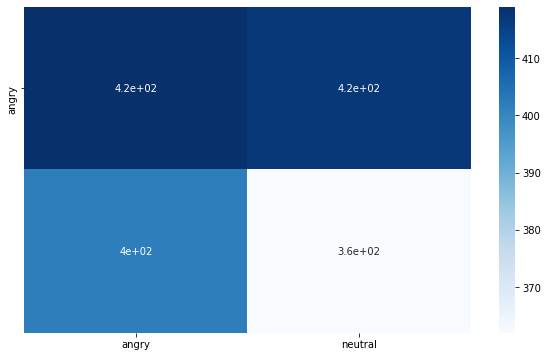

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

labels = observed_emotions
cm = confusion_matrix(y_true, y_pred, labels)
cm_df = pd.DataFrame(cm, labels, labels)
print(cm_df)
plt.figure(figsize=(10,6))
plt.ylabel("Actual")
plt.xlabel("Predicted")
sns.heatmap(cm_df, annot=True, cmap='Blues', yticklabels=len(observed_emotions))
plt.show()

In [ ]:
f = []
fn = []
prob = []
for file in glob.glob("C:\\Users\\acer-pc\\Desktop\\Audio\\Surrey Audio-Visual Expressed Emotion (SAVEE) Database\\AudioData\\JK\\*.wav"):
    file_name=os.path.basename(file)
    feature=np.expand_dims(extract_feature(file, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True).reshape(1, -1), axis=2)
    int_pred = onehotencoder.inverse_transform(model2.predict(feature))[0][0]
    pr = np.max(model2.predict(feature))
    f.append(int_pred)
    fn.append(file_name)
    prob.append(pr)
    
df = pd.concat([pd.Series(fn), pd.Series(f), pd.Series(prob)], axis=1)
df.columns = ['filename', 'emotion', 'prob']

In [ ]:
df.to_csv('c.csv')

Load model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model_CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test1, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
file = ("C:\\Users\\acer-pc\\Downloads\\LDC2007S09_neutral.wav")
file_name=os.path.basename(file)
feature=np.expand_dims(extract_feature(file, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True).reshape(1, -1), axis=2)
int_pred = model2.predict(feature)
int_preds = pd.DataFrame(int_pred)
int_preds.columns = observed_emotions
int_preds.idxmax(1)